# Flood Mapping Example

This notebook provides the code to reproduce the results of the paper for what concerns the flood data.

Due to the size of the data and models it is recommended to run on GPU (cuda).

## 0. Preamble



In [1]:
import os
import subprocess
import shutil

REPO_URL = "https://github.com/FractalySyn/PiNets-Alignment.git"
FOLDER = "floods"

if not os.path.exists(FOLDER):
    subprocess.run(
        ["git", "clone", "--filter=blob:none", "--no-checkout", "--sparse", REPO_URL, "tmp_clone"],
        check=True,
    )
    try:
        subprocess.run(["git", "-C", "tmp_clone", "sparse-checkout", "set", FOLDER], check=True)
        subprocess.run(["git", "-C", "tmp_clone", "checkout", "main"], check=True)
        shutil.copytree(os.path.join("tmp_clone", FOLDER), FOLDER, dirs_exist_ok=True)
    finally:
        shutil.rmtree("tmp_clone", ignore_errors=True)
else:
    print(f"Directory '{FOLDER}' already exists.")

Cloning into 'tmp_clone'...


Your branch is up to date with 'origin/main'.


Already on 'main'


The code chunk below will download the [Sen1Floods11](https://github.com/cloudtostreet/Sen1Floods11) dataset and the [Prithvi foundation model](https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M)

In [2]:
try:
  os.mkdir('floods/external_data/')
  !gsutil -m rsync -r -x ".*(JRCWaterHand|S1OtsuLabelHand|S1Hand).*" gs://sen1floods11/v1.1/data/flood_events/HandLabeled/ floods/external_data/
  !gsutil -m rsync -r gs://sen1floods11/v1.1/splits/flood_handlabeled/ floods/external_data/
  
  os.mkdir('floods/external_data/prithvi/')
  !git clone https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M floods/external_data/prithvi/
  %pip install -q rasterio
  
  print('Done downloading! The data is in the floods/external_data/ directory.')
except:
  print('The floods/external_data/ directory already exists! Skipping download. Verify that the data is present or remove the external_data/ folder and rerun.')


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_314919_LabelHand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_103757_LabelHand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_1078550_LabelHand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_129334_LabelHand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_294583_LabelHand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/Bolivia_23014_LabelHand.tif...
Copying gs://s

In [3]:
### Derandomization and determinism setup for reproducibibility
from floods.utils import env_reproducibility
env_reproducibility()

SEED = 2025            ## random seed for reproducibility

### Pytorch engine --- uses GPU (cuda) if available
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

If `RETRAIN` is set to `False`, the trained models from the github repo will be used. If `RETRAIN` is set to `True`, the models will be retrained from scratch (this requires more time and computational resources). 

In [4]:
RETRAIN = False

## 1. Satellite Data



In [5]:
import pandas as pd

DIR = 'floods/external_data/'

## we make our own split so we combine train and val sets here
train_df = pd.read_csv(DIR+'flood_train_data.csv', header=None)
val_df = pd.read_csv(DIR+'flood_valid_data.csv', header=None)
train_df = pd.concat([train_df, val_df], ignore_index=True)
del val_df

test_df = pd.read_csv(DIR+'flood_test_data.csv', header=None)

train_df.head(3)

,0,1
0,Ghana_103272_S1Hand.tif,Ghana_103272_LabelHand.tif
1,Ghana_24858_S1Hand.tif,Ghana_24858_LabelHand.tif
2,Ghana_147015_S1Hand.tif,Ghana_147015_LabelHand.tif


**Example of Sentinel-2 data and flood masks**

In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## plotting setup
colors = ['black', 'lightgray', 'teal']
cmap = mcolors.ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5] 
norm = mcolors.BoundaryNorm(bounds, cmap.N)

**Visualize a sample from the test set**

0       Nigeria_812045_S1Hand.tif
1    Nigeria_812045_LabelHand.tif
Name: 33, dtype: object


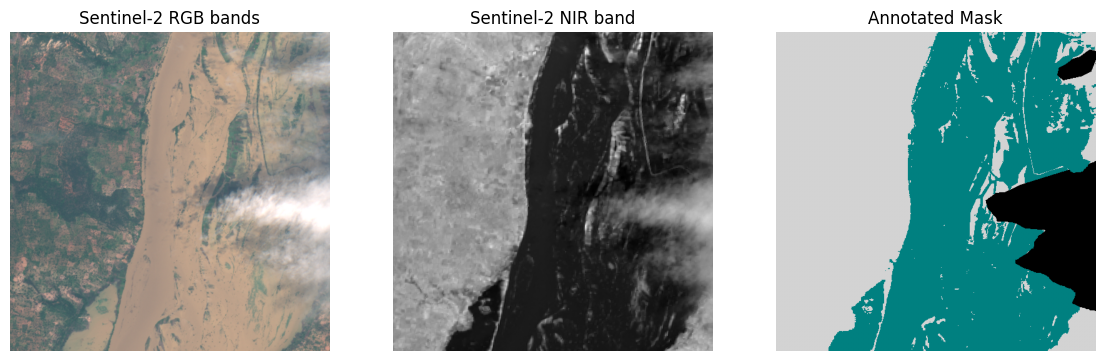

In [7]:
## visualize a sample from the test set
row = test_df.iloc[33]
print(row)

## load Sentinel-2 image and mask
S2_path = DIR+'S2Hand/' + row[0].replace('S1', 'S2')
mask_path = DIR+'LabelHand/' + row[1]
with rasterio.open(S2_path) as src:
  S2 = src.read()
with rasterio.open(mask_path) as src:
  mask = src.read(1)

## preprocess S2 for visualization
S2 = S2 / 3000.0
S2_nir = S2[8]
S2 = S2[[3,2,1]].transpose(1,2,0)

## plot
fig, axs = plt.subplots(1, 3, figsize=(14,5))
[ax.axis('off') for ax in axs]

axs[0].imshow(np.clip(S2, 0.0, 1.0))
axs[1].imshow(S2_nir, cmap='gray')
axs[2].imshow(mask, cmap= cmap, norm=norm);

axs[0].set_title('Sentinel-2 RGB bands')
axs[1].set_title('Sentinel-2 NIR band')
axs[2].set_title('Annotated Mask');

**Load images in memory**

In [8]:
import numpy as np
from floods.utils import load_X, load_pi

## load data (images X and masks pi*)
X_train = np.array([load_X(row, DIR) for _, row in train_df.iterrows()])
pi_star_train = np.array([load_pi(row, DIR) for _, row in train_df.iterrows()])

X_test = np.array([load_X(row, DIR) for _, row in test_df.iterrows()])
pi_star_test = np.array([load_pi(row, DIR) for _, row in test_df.iterrows()])

We downsample the 512x512 images and masks into four insets of dimensions 256x256

In [9]:
from floods.utils import split_into_insets, flatten_data, train_val_split, seed_all

X_train_insets = split_into_insets(X_train)  
pi_star_train_insets = split_into_insets(pi_star_train)  
area_train_insets = np.stack([(pi_star_train_insets==k).sum(axis=(2,3)) for k in [-1,0,1]], axis=2)

X_test_insets = split_into_insets(X_test)  
pi_star_test_insets = split_into_insets(pi_star_test)
area_test_insets = np.stack([(pi_star_test_insets==k).sum(axis=(2,3)) for k in [-1,0,1]], axis=2)

In [10]:
## Flatten data
X_train_flat, pi_star_train_flat, area_train_flat = \
  flatten_data(X_train_insets, pi_star_train_insets, area_train_insets)
X_test_flat, pi_star_test_flat, area_test_flat = \
  flatten_data(X_test_insets, pi_star_test_insets, area_test_insets)

# Train/validation split
seed_all(SEED)
X_train_flat, X_val_flat, pi_star_train_flat, pi_star_val_flat, area_train_flat, area_val_flat = \
  train_val_split(X_train_flat, pi_star_train_flat, area_train_flat, val_split=0.2)

# Prepare test scenes for visualization
S2_scenes = X_test_flat[:, [2,1,0]].permute(0,2,3,1).numpy()
S2_scenes = (S2_scenes - S2_scenes.min()) / (S2_scenes.max() - S2_scenes.min()) * (10000 / 3000)

## 2. Training

### 2.1. Hyperparameters 

In [11]:
import json

## Phritvi hyperparameters
with open(DIR+'prithvi/config.json', 'r') as file:
  config = json.load(file)['pretrained_cfg']

## modify config for our use case
config['mask_ratio'] = 0.0
config['img_size'] = 256
config['depth'] = 4

del config['mean'], config['std']
config

{'img_size': 256,
 'patch_size': [1, 16, 16],
 'num_frames': 3,
 'in_chans': 6,
 'embed_dim': 768,
 'depth': 4,
 'num_heads': 12,
 'decoder_embed_dim': 512,
 'decoder_depth': 8,
 'decoder_num_heads': 16,
 'mlp_ratio': 4,
 'mask_ratio': 0.0,
 'bands': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07'],
 'origin_url': 'https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M',
 'paper_ids': 'arXiv:2310.18660'}

In [12]:
BATCH_SIZE = 32        ## batch size for training
N_EPOCHS = 200         ## max training epochs
lr = 5e-3              ## initial learning rate
patience = 5           ## lr scheduler patience
factor = 0.2           ## lr scheduler division factor
ES = 1e-5              ## early stopping - loss threshold

load_pretrained = True   ## whether to load pretrained weights
freeze_encoder = True    ## whether to freeze encoder weights during training

In [13]:
from torch.utils.data import TensorDataset, DataLoader

seed_all(SEED)

## normalization
mu, sigma = X_train_flat.mean(dim=(0,2,3), keepdim=True), X_train_flat.std(dim=(0,2,3), keepdim=True)

## Create DataLoaders for pytorch
train_dataset = TensorDataset((X_train_flat-mu)/sigma, area_train_flat, pi_star_train_flat)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset((X_val_flat-mu)/sigma, area_val_flat, pi_star_val_flat)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset((X_test_flat-mu)/sigma, area_test_flat, pi_star_test_flat)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 2.2. Baseline SegNet

We train the baseline segmentation model with the binary cross entropy loss. Alternatively it can be trained with the false abstraction rate as a loss function. For this set `loss_='FAR'`

In [14]:
from floods.utils import free_ram, model_size
from floods.models import PiPrithvi

free_ram()
seed_all(SEED)

if RETRAIN:

  ## Initialize Pi-Prithvi model
  model = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                    load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
  model.to(device)
  model_size(model)

  ## Set loss and optimizer
  loss_ = 'BCE' # or FAR
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.AdamW(params, lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)

  path = 'floods/models/segnet.pt'

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [15]:
from floods.training import training

if RETRAIN:
  model = training(model, train_loader, val_loader, optimizer, scheduler, loss_, N_EPOCHS, device, ES=ES, path=path)

### 2.3. PiNet

We train the PiNet model with the mean absolute error. 

In [16]:
free_ram()
seed_all(SEED)

if RETRAIN:

  ## Initialize Pi-Prithvi model
  model = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                    load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
  model.to(device)
  model_size(model)

  ## Set loss and optimizer
  loss_ = 'MAE'
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.AdamW(params, lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)

  path = 'floods/models/pinet.pt'

In [17]:
if RETRAIN:
  model = training(model, train_loader, val_loader, optimizer, scheduler, loss_, N_EPOCHS, device, ES=ES, path=path)

## 3. Evaluation

In [18]:
from floods.training import eval

print('--------------------------- SegNet:')
seed_all(SEED)
segnet = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                      load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
segnet.load_state_dict(torch.load(f'floods/models/segnet.pt', map_location=device), strict=False)
pi_test_segnet = eval(segnet, test_loader, device) - 1.0

print('--------------------------- PiNet:')
seed_all(SEED)
pinet = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                      load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
pinet.load_state_dict(torch.load(f'floods/models/pinet.pt', map_location=device), strict=False)
pi_test_pinet = eval(pinet, test_loader, device) - 1.0

--------------------------- SegNet:
Test MAE: 2582, Test IoU water: 0.332, Test IoU no water: 0.814, Test TDR water: 0.904 Test TDR no water: 0.940
--------------------------- PiNet:
Test MAE: 1110, Test IoU water: 0.256, Test IoU no water: 0.819, Test TDR water: 0.802 Test TDR no water: 0.959


In [22]:
def delta(perf_baseline, perf):
  return round((perf - perf_baseline)  / perf_baseline * 100, 1)

delta(2582, 1110), delta(0.332, 0.256), delta(0.904, 0.802), delta(0.814, 0.819), delta(0.94, 0.959)

(-57.0, -22.9, -11.3, 0.6, 2.0)

In [20]:
from floods.utils import merge_insets

## prepare images for visualization
pi_test_segnet_insets = pi_test_segnet.reshape(-1, 4, 256, 256).numpy()
pi_test_segnet_merged = merge_insets(pi_test_segnet_insets)

pi_test_pinet_insets = pi_test_pinet.reshape(-1, 4, 256, 256).numpy()
pi_test_pinet_merged = merge_insets(pi_test_pinet_insets)

S2_scenes_insets = S2_scenes.reshape(-1, 4, 256, 256, 3)
S2_scenes_merged = merge_insets(S2_scenes_insets)

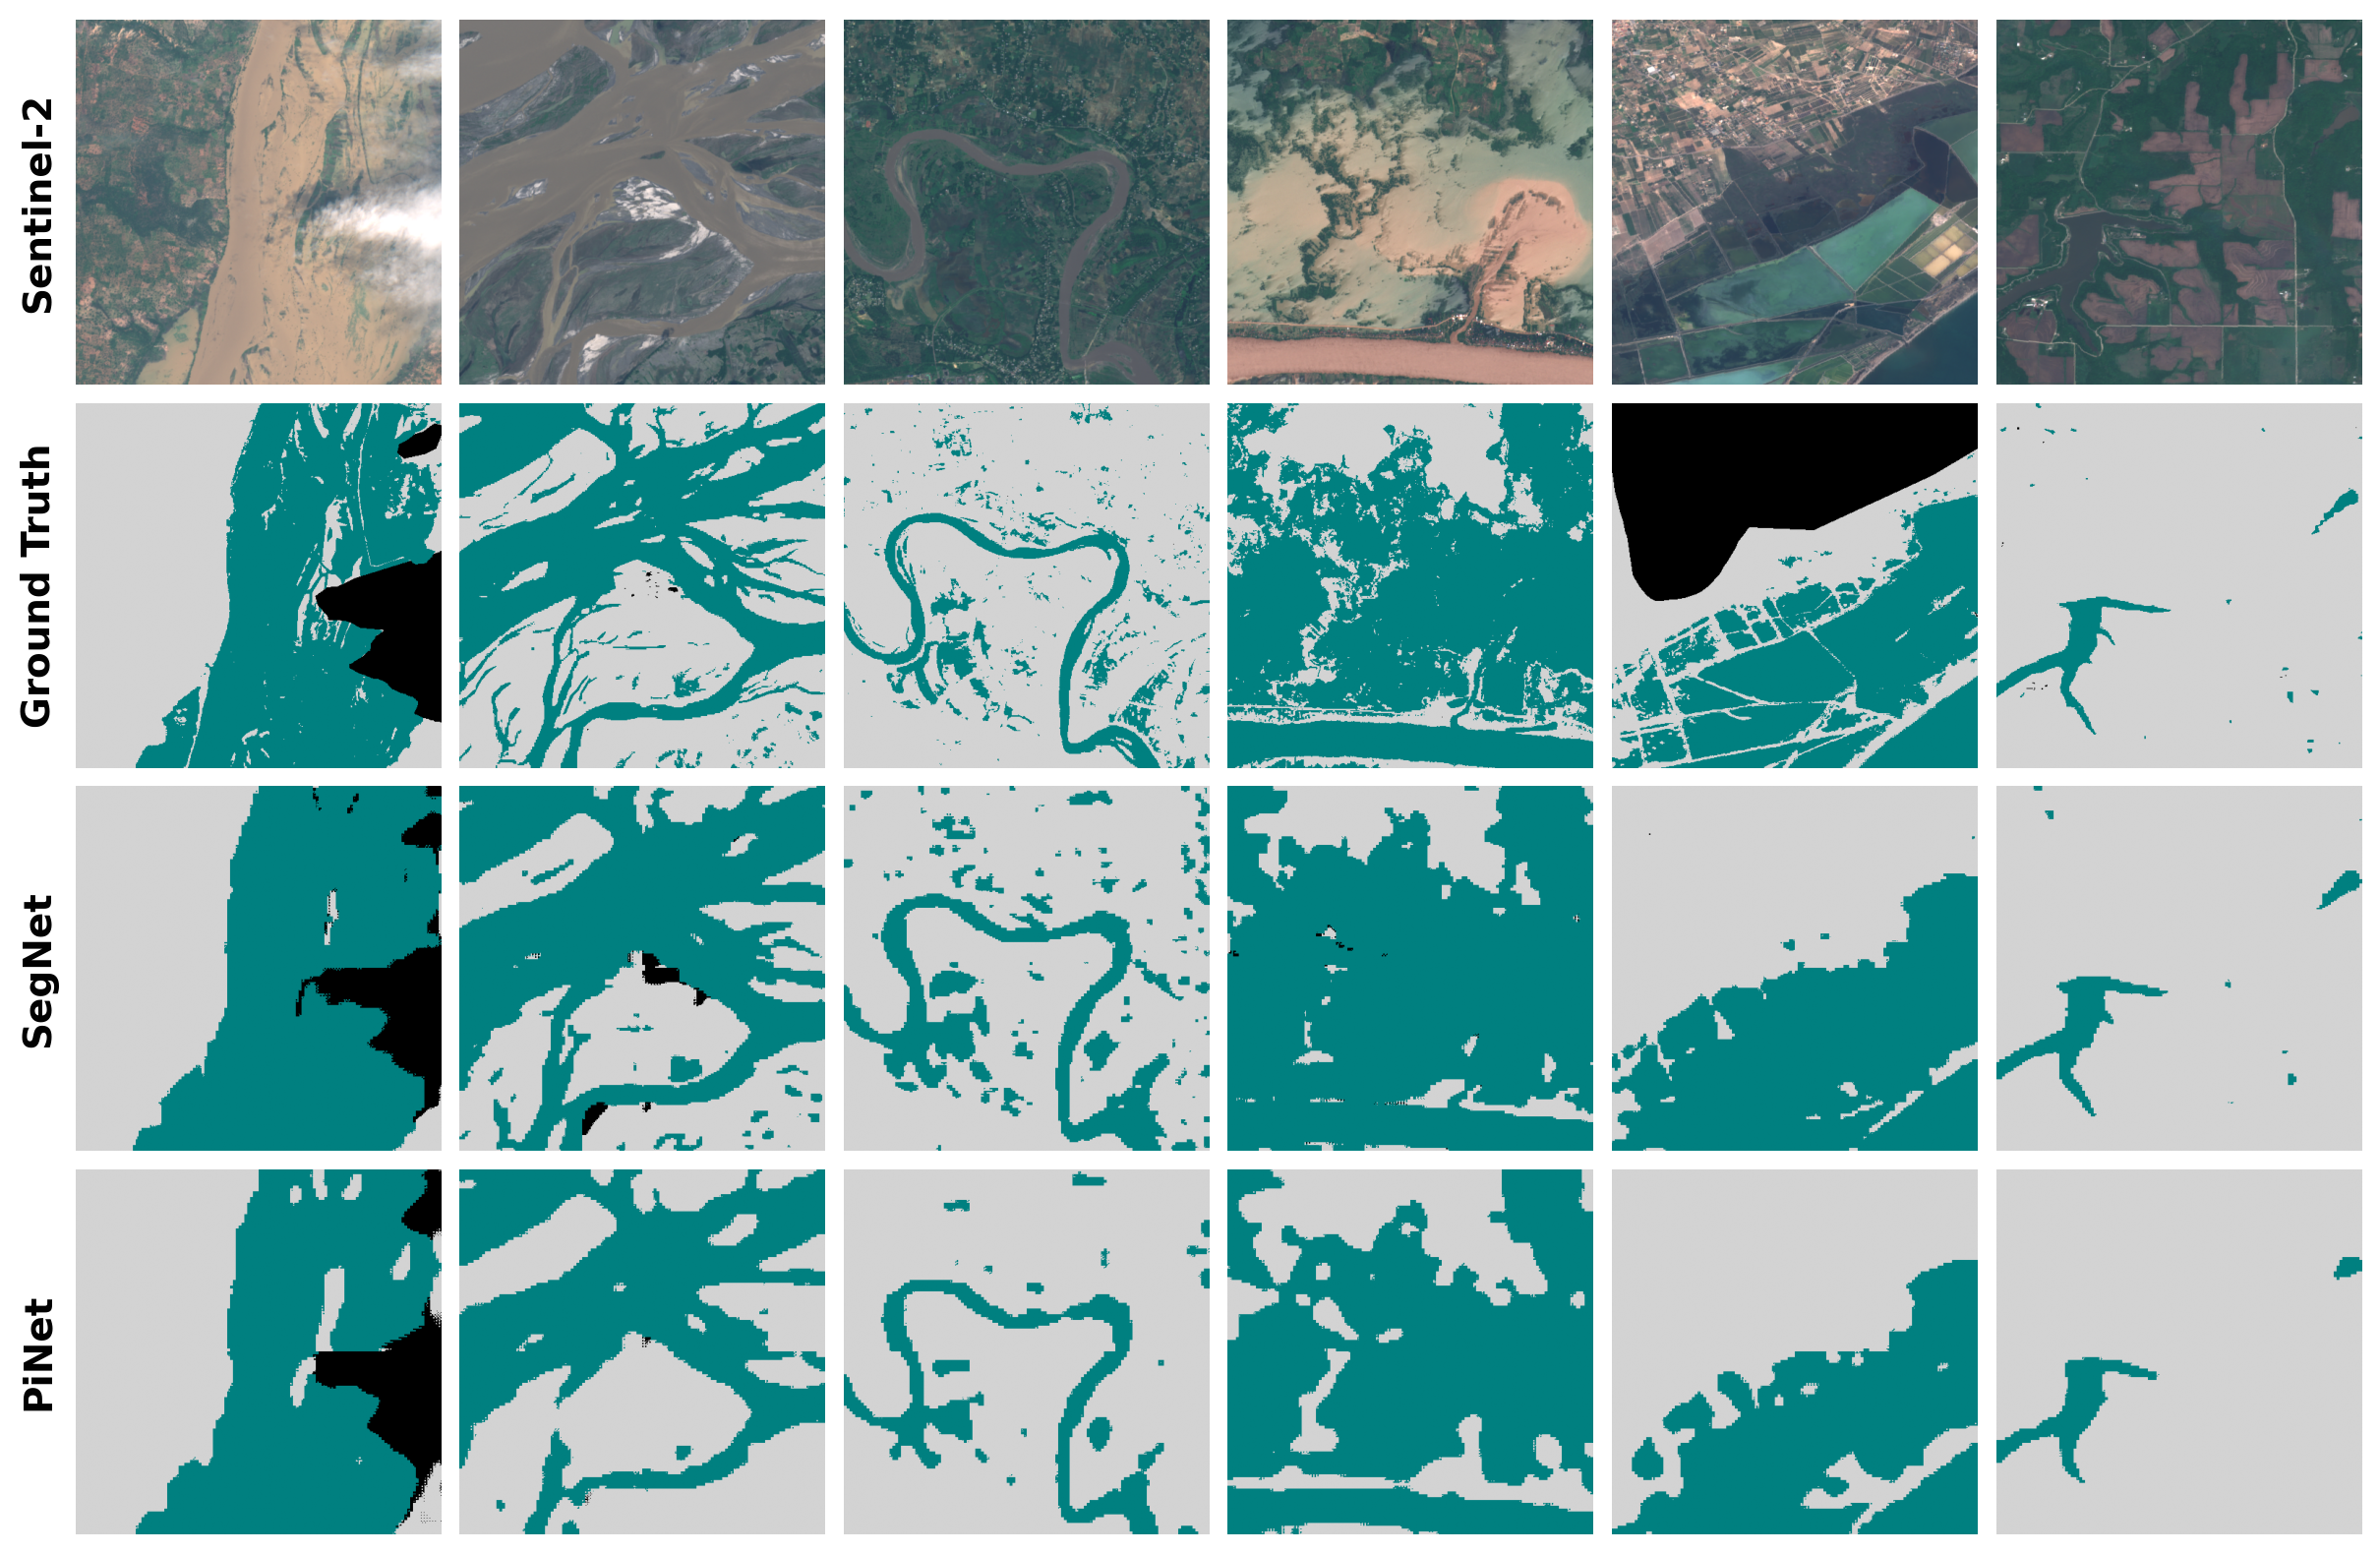

In [21]:
from floods.utils import visualize_predictions

selection = [33, 11, 20, 27, 63, 84]
visualize_predictions(pi_test_segnet_merged, pi_test_pinet_merged, pi_star_test, S2_scenes_merged*2, selection, 
                      names=('SegNet', 'PiNet'), cmap=cmap, norm=norm)

The resulting image is saved as `'floods.png'`